# 안개 발생 진단 분류 모델 데이터셋 전처리

## 1. 데이터 설명

- 컬럼

    - `Year` : 년도
    - `Month` : 월
    - `Day` : 일
    - `Time` : 시간 (0 ~ 23)
    - `Minute` : 분 (10분 단위)
    - `STN_ID` : 지점 번호
    - `WS10(deg)` : 10분 평균 풍향, 단위: deg
    - `WS10(m/s)` : 10분 평균 풍속, 단위: m/s
    - `TA` : 1분 평균 기온 10분 주기, 단위: C
    - `RE` : 강수 유무 (0:무강수, 1:강수)
    - `HM` : 1분 평균 상대 습도 10분 주기, 단위: %
    - `sun10` : 1분 일사량 10분단위 합계, 단위: MJ
    - `TS` : 1분 평균 지면온도 10분 주기, 단위: C
    - `VIS1` : 1분 평균 시정 10분 주기, 단위: C (VIS1 변수는 시정 구간을 알 수 있는 변수로 검증 데이터에서는 제외)
    - `class` : 시정 구간

- 시정 계급 기준 (비고: 안개의 기준)

    - `1` : 0 < 시정 < 200
    - `2` : 200 <= 시정 < 500
    - `3` : 500 <= 시정 < 1000
    - `4` : 1000 <= 시정


## 2. 데이터 불러오기

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams

import os
import pickle

import warnings
warnings.filterwarnings(action='ignore')

plt.rc('font', family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False

### 2-1. 로컬 디렉토리 경로

In [2]:
# 작업 디렉토리 변경 (로컬 디렉토리에서 작업시 실행)

def get_local_path(train_dataset_name, test_dataset_name):

    # 작업 디렉토리 origin_dir에 선언
    origin_dir = os.getcwd()

    # ".." : 상위 디렉토리로 이동
    os.chdir("..")

    # 상위 디렉토리에 fog_data가 없다면 fog_data 폴더 생성
    # (이미 폴더 있어도 exist_ok=True면 넘어감)
    os.makedirs("fog_data", exist_ok=True)

    # train/test 데이터셋 경로 잡아준다
    train_path = os.path.join(os.getcwd(), "fog_data", train_dataset_name)
    test_path = os.path.join(os.getcwd(), "fog_data", test_dataset_name)

    # 운영체제가 윈도우일 경우, "\\"를 "/"로 바꿔줘야 한다
    if os.name == "nt":
        train_path = train_path.replace("\\", "/")
        test_path = test_path.replace("\\", "/")

    # origin_dir로 경로 다시 변경 (초기화)
    os.chdir(origin_dir)

    return train_path, test_path

In [3]:
train_path, test_path = get_local_path("fog_train.csv", "fog_test.csv")

In [4]:
print(train_path)
print(test_path)

c:/Users/aryij/Documents/DataStudy/fog_data/fog_train.csv
c:/Users/aryij/Documents/DataStudy/fog_data/fog_test.csv


### 2-2. colab 디렉토리 경로 (colab 작업시)

In [5]:
# 구글 드라이브 파일 접근
# from google.colab import drive
# drive.mount('/content/drive')

In [6]:
# colab 파일 경로 생성 함수
# colab에서 작업시 주석 풀고 실행

# def get_colab_path(train_dataset_name, test_dataset_name):
    
#     fog_folder = "drive/MyDrive/weather-contest/fog_data"
#     os.makedirs(fog_folder, exist_ok=True)

#     # train/test 데이터셋 경로 잡아준다
#     train_path = os.path.join(os.getcwd(), fog_folder, train_dataset_name)
#     test_path = os.path.join(os.getcwd(), fog_folder, test_dataset_name)

#     return train_path, test_path

In [7]:
# train_path, test_path = get_colab_path("fog_train.csv", "fog_test.csv")

## 3. 데이터셋 로드

In [8]:
# 데이터셋 불러오기
fog_train_df = pd.read_csv(train_path, index_col=0).rename(columns=lambda x: x.split('.')[1]).reset_index(drop=True)
fog_test_df = pd.read_csv(test_path, index_col=0).rename(columns=lambda x: x.split('.')[1]).reset_index(drop=True)

In [9]:
fog_train_df.head(3)

,year,month,day,time,minute,stn_id,ws10_deg,ws10_ms,ta,re,hm,sun10,ts,vis1,class
0,I,1,1,0,10,AA,0.0,0.0,-6.4,0.0,38.9,0.0,-2.8,20000,4
1,I,1,1,0,20,AA,0.0,0.0,-6.3,0.0,37.9,0.0,-2.7,20000,4
2,I,1,1,0,30,AA,0.0,0.0,-6.3,0.0,40.0,0.0,-2.6,20000,4


In [10]:
fog_test_df.head(3)

,year,month,day,time,minute,stn_id,ws10_deg,ws10_ms,ta,re,hm,sun10,ts,class
0,L,1,1,0,0,AI,329.5,0.6,-2.5,0.0,87.5,0.0,-1.6,NaN
1,L,1,1,0,10,AI,321.8,1.2,-2.5,0.0,88.2,0.0,-1.6,NaN
2,L,1,1,0,20,AI,0.4,0.4,-2.5,0.0,88.6,0.0,-1.7,NaN


## 4. Preprocessing

### 4-1. 컬럼 수정 및 제거
- 데이터셋 공통 : `stn_id` 맨 앞의 대문자만 가져온다

- Train 데이터셋 : `year`, `month`, `day`, `time`, `minute`, `vis1` 컬럼 제거
- Test 데이터셋 : `year`, `month`, `day`, `time`, `minute` 컬럼 제거

In [11]:
def modify_columns(train_df, test_df):

    # stn_id 수정 : A, B, C, D, E로 수정
    train_df["stn_id"] = train_df["stn_id"].apply(lambda x: x[0])
    test_df["stn_id"] = test_df["stn_id"].apply(lambda x: x[0])

    # year, month, day, time, minute, 컬럼 drop
    train_df.drop(columns=["year", "month", "day", "time", "minute", "vis1"], inplace=True)
    test_df.drop(columns=["year", "month", "day", "time", "minute"], inplace=True)

    return train_df, test_df

In [12]:
train_df, test_df = modify_columns(fog_train_df, fog_test_df)

In [13]:
fog_train_df.head(3)

,stn_id,ws10_deg,ws10_ms,ta,re,hm,sun10,ts,class
0,A,0.0,0.0,-6.4,0.0,38.9,0.0,-2.8,4
1,A,0.0,0.0,-6.3,0.0,37.9,0.0,-2.7,4
2,A,0.0,0.0,-6.3,0.0,40.0,0.0,-2.6,4


### 4-2. 결측치 확인 및 제거
- 결측치 : 값이 `-99`, `-99.9`인 데이터

In [14]:
# -99, -99.9인 데이터를 np.nan으로 치환하는 함수

def switch_to_nan(train_df, test_df):
    
    train_df = train_df.replace({-99:np.nan, -99.9:np.nan})
    test_df = test_df.replace({-99:np.nan, -99.9:np.nan})
    
    return train_df, test_df

In [15]:
train_df, test_df = switch_to_nan(train_df, test_df)

In [16]:
# train 데이터 결측치 확인
train_df.isnull().sum()

stn_id          0
ws10_deg     5910
ws10_ms      5826
ta           3867
re          15228
hm           3616
sun10       43910
ts          88639
class       22516
dtype: int64

In [17]:
# test 데이터 결측치 확인
test_df.isnull().sum()

stn_id           0
ws10_deg       224
ws10_ms        224
ta              91
re            4503
hm              57
sun10          115
ts            7643
class       262800
dtype: int64

In [18]:
# 컬럼별 결측치 확인

def nan_rate_by_cols(train_df, test_df):

    # train_df에서 np.nan인 데이터
    nan_tr = train_df.isnull().sum()
    nan_tr_cnt = train_df.isnull().count()

    # test_df에서 np.nan인 데이터
    nan_test = test_df.isnull().sum()
    nan_test_cnt = test_df.isnull().count()

    nan_tr_pct = round((nan_tr/nan_tr_cnt)*100, 1)
    nan_test_pct = round((nan_test/nan_test_cnt)*100, 1)

    missing = pd.concat([nan_tr, nan_tr_pct, nan_test, nan_test_pct],
                        keys=["train_nan", "train_nan_pct", "test_nan", "test_nan_pct"], axis=1)
    return missing

In [19]:
# 컬럼별 결측치 확인하여, 합계 및 비율을 구한 비교 데이터프레임 생성 (target 컬럼인 class는 합계에서 제외)

missing = nan_rate_by_cols(train_df, test_df)
missing_sum = pd.DataFrame({"train_nan" : np.sum(missing["train_nan"])-missing.loc["class", "train_nan"],
                            "train_nan_pct" : np.round(((np.sum(missing["train_nan"])-missing.loc["class", "train_nan"]) / train_df.shape[0])*100, 3),
                            "test_nan" : np.sum(missing["test_nan"])-missing.loc["class", "test_nan"],
                            "test_nan_pct" : np.round(((np.sum(missing["test_nan"])-missing.loc["class", "test_nan"]) / test_df.shape[0]*100), 3)},
                            index=["sum except class"]
                            )
missing_total = pd.concat([missing, missing_sum])

In [20]:
missing_total

,train_nan,train_nan_pct,test_nan,test_nan_pct
stn_id,0,0.000,0,0.000
ws10_deg,5910,0.200,224,0.100
ws10_ms,5826,0.200,224,0.100
ta,3867,0.100,91,0.000
re,15228,0.500,4503,1.700
hm,3616,0.100,57,0.000
sun10,43910,1.400,115,0.000
ts,88639,2.800,7643,2.900
class,22516,0.700,262800,100.000
sum except class,166996,5.291,12857,4.892


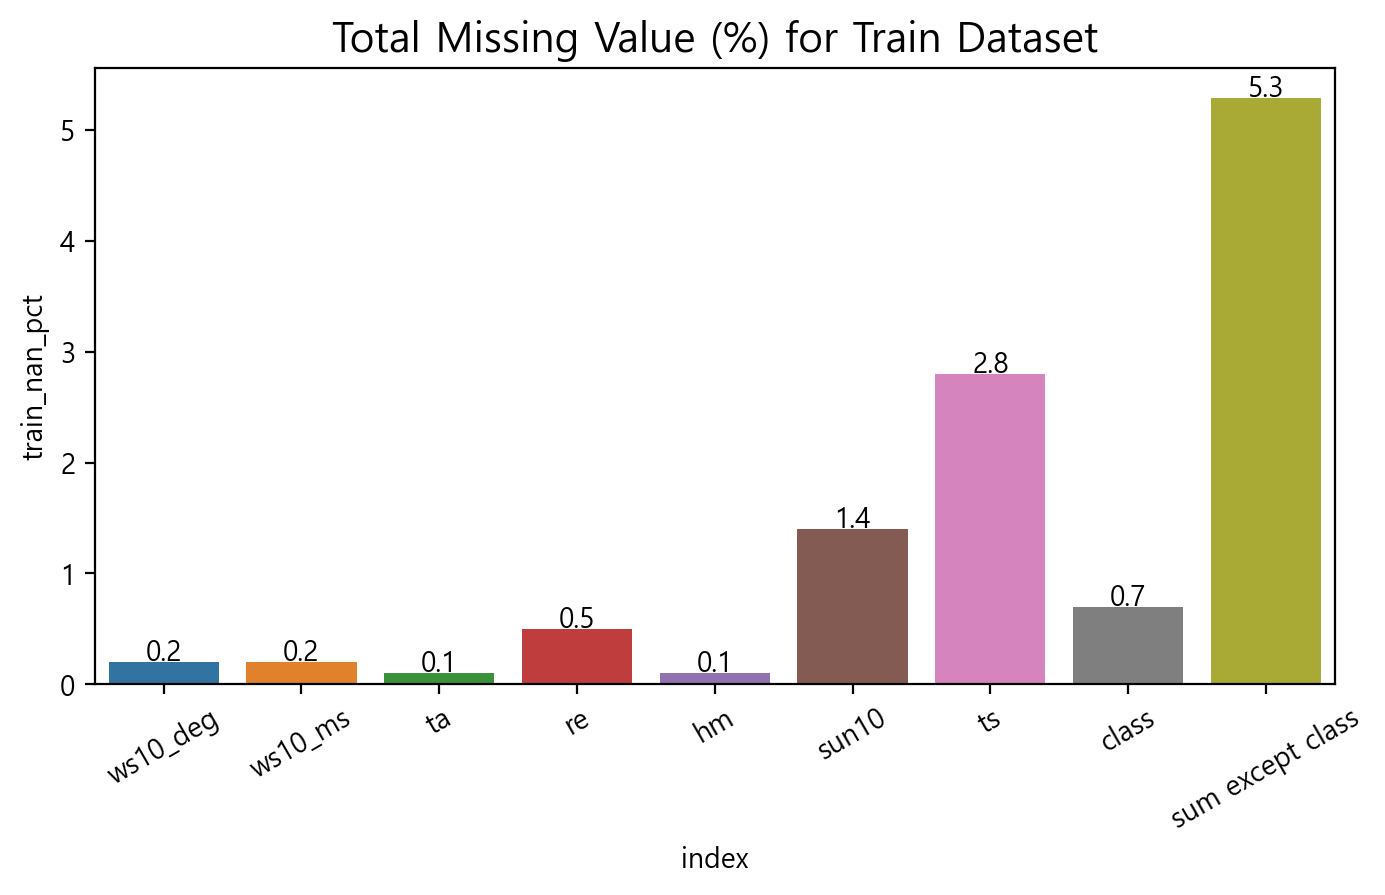

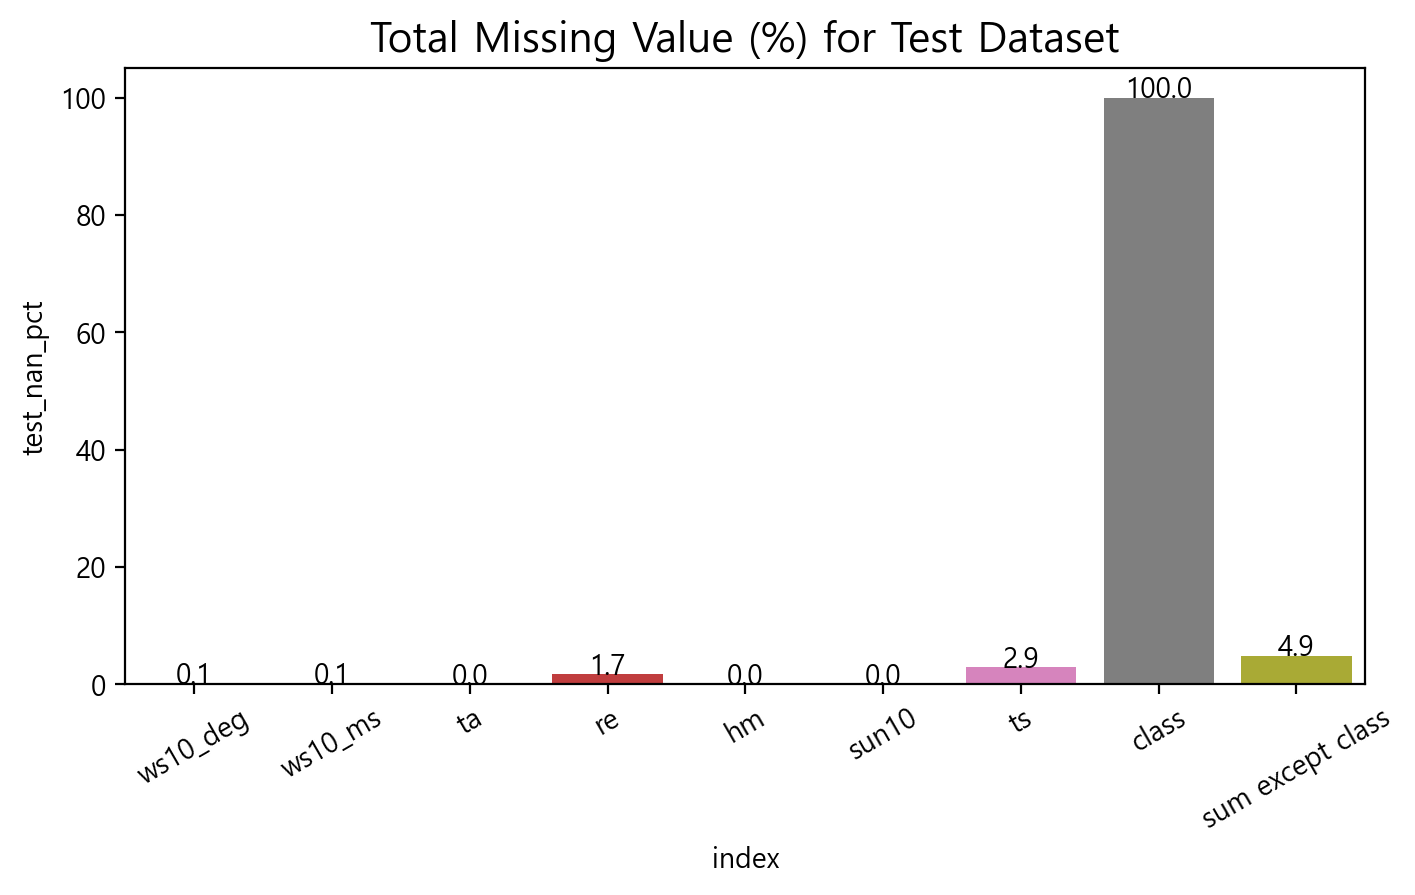

In [21]:
# 결측치 비율 시각화
plt.figure(figsize=(8, 4))
sns_pct = sns.barplot(x="index", y="train_nan_pct", data=missing_total[missing_total["train_nan"]!=0].reset_index())
sns_pct.set_xticklabels(sns_pct.get_xticklabels(), rotation=30)

# bar 그래프 상단에 비율 (%) 표기
for bar in sns_pct.patches:
    height = bar.get_height()                   # .get_height() : y좌표

    plt.text(bar.get_x() + bar.get_width()/2,   # 퍼센트 글자 위치
             height+0.01,                       # 퍼센트 글자 높이
             "%.1f" % height,                   # 퍼센트 소수점 지정
             ha="center")                       # 가운데 정렬

# 시각화 제목 이름, 폰트 크기 지정
sns_pct.set_title("Total Missing Value (%) for Train Dataset", fontsize=15)
# plt.show()

# 결측치 비율 시각화
plt.figure(figsize=(8, 4))
sns_pct = sns.barplot(x="index", y="test_nan_pct", data=missing_total[missing_total["test_nan"]!=0].reset_index())
sns_pct.set_xticklabels(sns_pct.get_xticklabels(), rotation=30)

# bar 그래프 상단에 비율 (%) 표기
for bar in sns_pct.patches:
    height = bar.get_height()                   # .get_height() : y좌표

    plt.text(bar.get_x() + bar.get_width()/2,   # 퍼센트 글자 위치
             height+0.01,                       # 퍼센트 글자 높이
             "%.1f" % height,                   # 퍼센트 소수점 지정
             ha="center")                       # 가운데 정렬

# 시각화 제목 이름, 폰트 크기 지정
sns_pct.set_title("Total Missing Value (%) for Test Dataset", fontsize=15)
plt.show()

### 4-3. 결측치 제거
- 결측치 비율에 따른 결측치 처리 방법 선택

    - 결측치 비율 `10% 미만` : 제거 또는 대체
    - 결측치 비율 `10% 이상 20% 미만` : 모델 기반 처리
    - 결측치 비율 `20% 이상` : 모델 기반 처리
    - 출처 : https://cheris8.github.io/data%20analysis/DP-NA-Imputation/

In [22]:
# train 데이터셋 결측치 제거
train_df.dropna(inplace=True)

In [23]:
train_df.isnull().sum()

stn_id      0
ws10_deg    0
ws10_ms     0
ta          0
re          0
hm          0
sun10       0
ts          0
class       0
dtype: int64

### 4-4. 결측치 제거 후 Target 변수 분포 확인 (Train 데이터)

In [24]:
# 컬럼의 값 분포를 확인하는 함수
def check_distribution_in_columns(df, column):
    # 해당 column의 값 value_counts()
    cnt = df[column].value_counts()
    cnt_pct = df[column].value_counts(normalize=True)

    # value_counts()한 값을 바탕으로, 데이터프레임 생성
    cnt_df = np.round(cnt.to_frame().reset_index().sort_values(column).set_index(column), 3)
    cnt_pct_df = np.round(cnt_pct.to_frame().reset_index().sort_values(column).set_index(column) * 100, 3).astype(str) + '%'

    distribution_df = pd.concat([cnt_df, cnt_pct_df], axis=1)

    return distribution_df

In [25]:
# Target 변수인 class 컬럼 데이터 분포 확인
class_distribution = check_distribution_in_columns(train_df, "class")
class_distribution

,count,proportion
class,,
1.0,7806,0.261%
2.0,11975,0.4%
3.0,11940,0.399%
4.0,2963129,98.941%


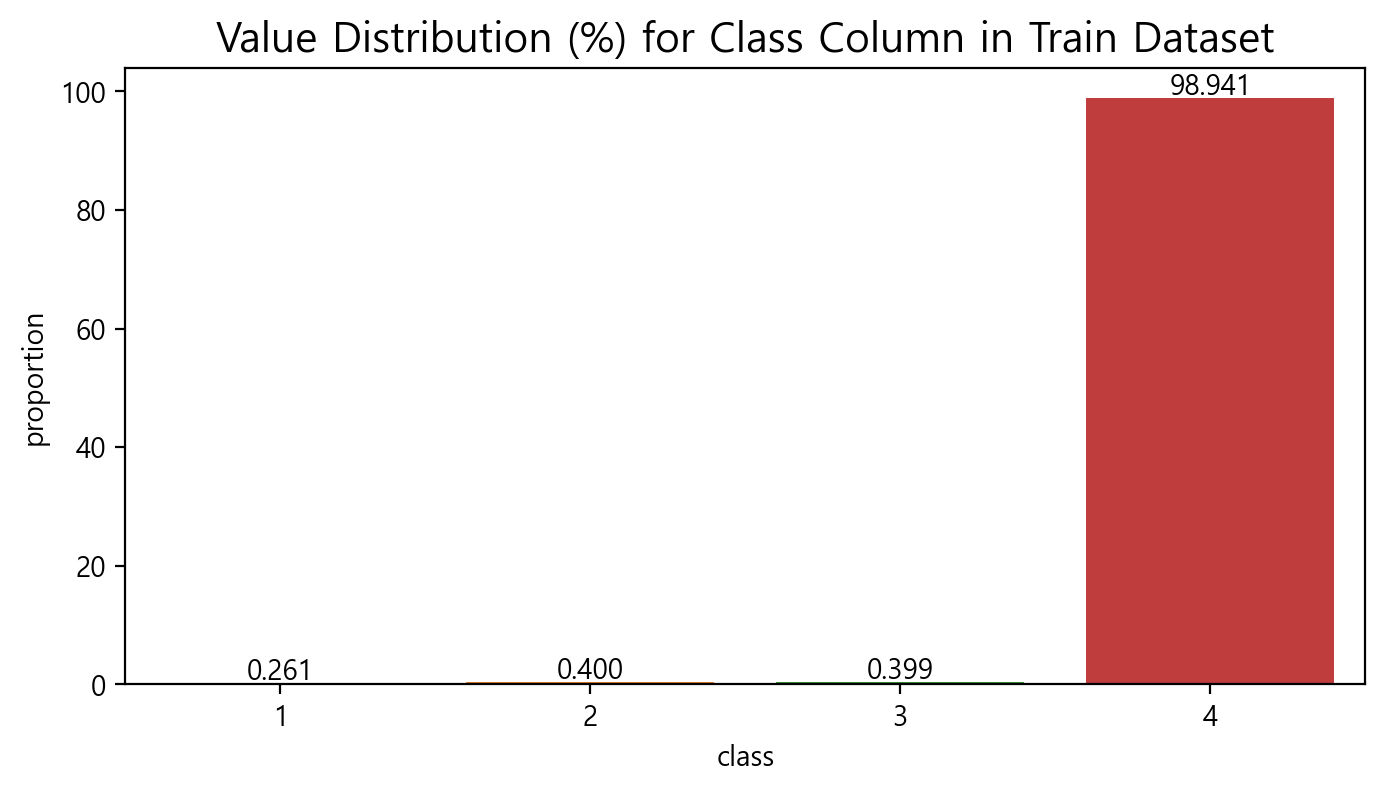

In [27]:
# 시각화 위해 위에서 구한 class_distribution 복사
class_distribution_no_pct = class_distribution.reset_index().copy()

# 시각화 위해 컬럼 수정
# proportion 컬럼 "%" 글자 제거 및 float로 변경
class_distribution_no_pct["proportion"] = class_distribution_no_pct["proportion"].apply(lambda x: float(x.split("%")[0]))

# class 컬럼 문자형으로 변경
class_distribution_no_pct["class"] = class_distribution_no_pct["class"].apply(lambda x: str(int(x)))


# 결측치 비율 시각화
plt.figure(figsize=(8, 4))
sns_pct = sns.barplot(x="class", y="proportion", data=class_distribution_no_pct)
# sns_pct.set_xticklabels(sns_pct.get_xticklabels(), rotation=30)

# bar 그래프 상단에 비율 (%) 표기
for bar in sns_pct.patches:
    height = bar.get_height()                   # .get_height() : y좌표

    plt.text(bar.get_x() + bar.get_width()/2,   # 퍼센트 글자 위치
             height+0.5,                        # 퍼센트 글자 높이
             "%.3f" % height,                   # 퍼센트 소수점 지정
             ha="center")                       # 가운데 정렬

# 시각화 제목 이름, 폰트 크기 지정
sns_pct.set_title("Value Distribution (%) for Class Column in Train Dataset", fontsize=15)
plt.show()

## 5. 전처리 마친 데이터 확인 후 저장

In [28]:
train_df.shape, test_df.shape

((2994850, 9), (262800, 9))

In [29]:
# 전처리 마친 데이터셋 저장할 경로 설정하는 함수

def save_local_path(train_df, test_df):
        
    # 작업 디렉토리 origin_dir에 선언
    origin_dir = os.getcwd()

    # ".." : 상위 디렉토리로 이동
    os.chdir("..")

    # 전처리 거친 데이터셋 저장할 이름 지정
    save_name_train = "fog_train_modified.csv"
    save_name_test = "fog_test_modified.csv"

    # 전처리 거친 데이터셋 저장 경로 설정
    train_save_path = os.path.join(os.getcwd(), "fog_data", save_name_train)
    test_save_path = os.path.join(os.getcwd(), "fog_data", save_name_test)
    
    # 운영체제가 윈도우일 경우, "\\"를 "/"로 바꿔줘야 한다
    if os.name == "nt":
        train_save_path = train_save_path.replace("\\", "/")
        test_save_path = test_save_path.replace("\\", "/")

    # # origin_dir로 경로 다시 변경 (초기화)
    os.chdir(origin_dir)

    return train_save_path, test_save_path

In [ ]:
def save_colab_path(train_df, test_df):
    origin_dir = os.getcwd()

    # 전처리 거친 데이터셋 저장할 이름 지정
    save_name_train = "fog_train_modified.csv"
    save_name_test = "fog_test_modified.csv"

    # 전처리 거친 데이터셋 저장 경로 설정
    train_save_path = os.path.join(train_path[:48], save_name_train)
    test_save_path = os.path.join(test_path[:48], save_name_test)
    
    return train_save_path, test_save_path

In [30]:
# 데이터셋 저장 경로 함수 적용 후 확인
train_save_path, test_save_path = save_local_path(train_df, test_df)

print(train_save_path)
print(test_save_path)

c:/Users/aryij/Documents/DataStudy/fog_data/fog_train_modified.csv
c:/Users/aryij/Documents/DataStudy/fog_data/fog_test_modified.csv


In [31]:
# 전처리 마친 데이터셋 저장
train_df.to_csv(train_save_path, index=False, encoding="utf-8")
test_df.to_csv(test_save_path, index=False, encoding="utf-8")